# Water Quality
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Water%20quality.png" />
[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)
Product for calculation of Turbidity, via the Normalised Difference Turbidity Index (NDTI) in water bodies.




### Import required modules

In [1]:
# jupyteronly

%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube_utilities.interactive_maps import display_map

In [2]:
from pyproj import Proj, transform
from datacube.storage import masking
from datacube.utils.cog import write_cog
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.dc_water_quality import tsm
from datacube_utilities.dc_water_classifier import wofs_classify

from datetime import datetime
from datetime import date
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/distributed/client.py:1138: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | client | scheduler | workers |
+-------------+--------+-----------+---------+
| blosc       | 1.9.1  | 1.10.2    | 1.10.2  |
| cloudpickle | 1.5.0  | 2.0.0     | 2.0.0   |
| distributed | 2.24.0 | 2.30.1    | 2.30.1  |
| lz4         | 3.1.0  | 3.1.1     | 3.1.1   |
| msgpack     | 1.0.0  | 0.6.1     | 0.6.1   |
| numpy       | 1.18.1 | 1.18.5    | 1.18.5  |
| tornado     | 6.0.4  | 6.0.3     | 6.0.3   |
+-------------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [3]:
# jupyteronly
dc = datacube.Datacube(app='waterquality')

### Set up parameters for cube query.

These parameters are set in a way which enables direct access to the Common Sensing datacube API.

In [35]:
# parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt",
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"
#aoi_wkt = "POLYGON((178.51212272613253 -18.079025694549387,178.57289085357397 -18.079025694549387,178.57289085357397 -18.15113922408976,178.51212272613253 -18.15113922408976,178.51212272613253 -18.079025694549387))"
#Sigatoka
aoi_wkt = "POLYGON((177.5029362281993 -18.156155117453817,177.53100286333114 -18.156155117453817,177.53100286333114 -18.18062057733904,177.5029362281993 -18.18062057733904,177.5029362281993 -18.156155117453817))"
#this is a constant across FIJI so maybe put it not as a variable but built into query. 

#set start and end dates for time period of interest
#parameter display_name="Start Date" description='Start of time period window' datatype="date"
baseline_time_start = '2018-2-1'
#parameter display_name="End Date" description='End of time period window' datatype="date"
baseline_time_end = '2018-4-28'

#set resolution
#parameter display_name="Resolution (m)" description="Size of pixels" datatype="int" 
res = (30)

#choose sensor
#parameter display_name="Sensor" description="Satellite to use." datatype="string" options=["sentinel_2", "landsat_4", "landsat_5", "landsat_7", "landsat_8"],
platform = "landsat_8"

#parameter display_name="Mosaic Type" description="The type of mosaic." datatype="string" options=["max", "median", "min", "mean"],
mosaic_type = "median"

#parameter which determines what water threshold we accept as being water. Restrict to be between 0 and 1. 
#parameter display_name="Water Threshold" description="The value for how strict the water masking should be, ranging from 0 for always land and 1 for always water." datatype="float" options=[0,1]
waterThresh = 0.9

#parameter display_name="Coordinate Reference System (ESPG Code)" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"


In [36]:
#this option is currently single, so not in parameters section, if more indices introduced then move into the above cell.
#parameter display_name="Indices Type" description="The type of Indices." datatype="string" options=["NDTI"],
index = 'NDTI'

### Reformat parameters

In [37]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [38]:
# jupyteronly
#render map to check AOI
display_map(latitude = lat_extents, longitude = lon_extents)

In [40]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3868901.244395433, 3871629.1723798118)
(1868059.9773457798, 1871011.4740391725)


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  
/

#name required products and measurements
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        water_product = 's2_water_mlclassification'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_mlclassification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_mlclassification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product
product, measurements, water_product = create_product_measurement(platform)

In [41]:
allmeasurements = ["green","red","blue","nir","swir16","swir22"]
#water_measurements = ["water_classification"]
water_measurements = ['watermask']
def create_product_measurement(platform):
    if platform  in ["sentinel_2"]:
        product = 'sentinel_2'
        measurements = ["green","red","blue","nir08","swir16","swir22","scene_classification"]
        water_product = 'sentinel_2_mlwater'
    elif platform in ["landsat_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_8'
        water_product = 'landsat_8_mlwater'
    elif platform in ["landsat_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_7'
        water_product = 'landsat_7_mlwater'
    elif platform in ["landsat_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_5'
        water_product = 'landsat_5_mlwater'
    elif platform in ["landsat_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_4'
        water_product = 'landsat_4_wofs'
    else:
        print("invalid platform")
    return product, measurements, water_product

product, measurement, water_product = create_product_measurement(platform)

In [42]:
#create resolution
resolution = (-res, res)

In [43]:
dask_chunks = dict(
    time = 10,
    x = 600,
    y = 600
)

In [44]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    yearWater = startDates.year
    waterDateA = date(yearWater, 1, 1)
    waterDateB = date(yearWater, 12, 31)
    endDates = end.date()
    time_period = (startDates, endDates)
    time_period_water = (waterDateA, waterDateB)
    return time_period, time_period_water
    
time_range, time_range_water = createDate(baseline_time_start, baseline_time_end)

In [45]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': "EPSG:"+crs,  
    'resolution': resolution,
    'dask_chunks' : dask_chunks,
    'crs': "EPSG:"+crs
}

### Load databased on cube query

In [46]:
ds = dc.load(
    product = product,
    platform = platform,
    measurements = measurement,
    time = time_range,
    **query
)
ds

<xarray.Dataset>
Dimensions:      (time: 17, x: 99, y: 92)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-02 2018-02-04 ... 2018-04-25
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    pixel_qa     (time, y, x) uint16 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [47]:
#check if loads have returned valid data
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


In [48]:
#rename S2 nir band from nir08 to nir
if platform  in ["sentinel_2"]:
    ds = ds.rename({'nir08': 'nir'})
else:
    print('correct bands exist')

correct bands exist


### Mask Clouds

In [49]:
def look_up_clean(platform, ds):
    if platform  in ["sentinel_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            #(ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["landsat_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["lansat_7", "landsat_5", "landsat_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [50]:
good_quality = look_up_clean(platform, ds)

In [51]:
ds_clear = ds.where(good_quality)
ds_clear

<xarray.Dataset>
Dimensions:      (time: 17, x: 99, y: 92)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-02 2018-02-04 ... 2018-04-25
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(10, 92, 99), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

## Create and apply masks, so only areas of water are analysed.

These masks are pre-created, all the water masks for the year of the first date are loaded in to identify areas of permament water bodies.

A full years worth of water masks are used for this, as assessments of water quality should be made on permament water bodies. Using a full years worth of masks reduces the influence of errors. 

In [52]:
def loadWaterMask(productInput, time_period):
    if productInput in ["sentinel_2_mlwater", "landsat_8_mlwater", "landsat_7_mlwater", "landsat_5_mlwater"]:
        water_scenes = dc.load(product=productInput, 
                               measurements = ["water_ml", "waterprob_ml"],
                               time = time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        #change clouds to no data value
        else:
            water_classes = water_scenes.where(water_scenes >= 0)
            good_quality_water = (
               (water_scenes.water_ml >= 0) & # no data
                (
                 (water_scenes.waterprob_ml <= 5) |
                    (water_scenes.waterprob_ml >= 100-5)
                )
                )
            water_classes = water_scenes.where(good_quality_water)
            water_classes['waterprob_ml'] = (100-water_classes['waterprob_ml']) # assign nodata vals consistent w/ other prods
            product_data = water_classes
    elif productInput in ['landsat_4_wofs']:
        water_scenes = dc.load(product=productInput,
                               measurements = ["water_wofs"],
                               time = time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        else:
            water_classes1 = water_scenes.where(water_scenes != -9999)
            water_classes1['water_ml'] = water_classes1['water_wofs']
            water_classes = water_classes1.drop(['water_wofs'])
            product_data = water_classes
    else:
        print('invalid platform')
    return product_data

In [53]:
water_dataset = loadWaterMask(water_product, time_range_water)

In [54]:
#create a composite of the years water masks. 
water_composite = water_dataset.water_ml.mean(dim='time')

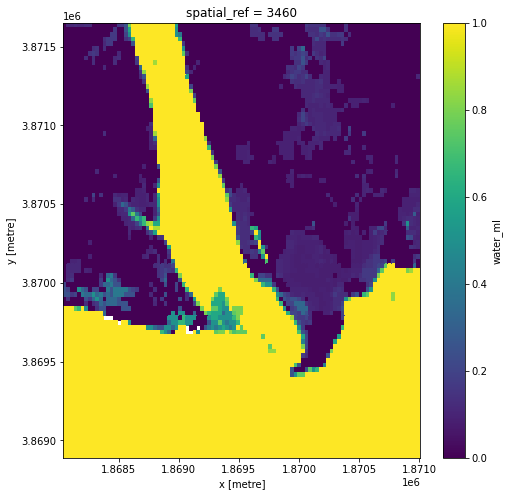

In [55]:
# jupyteronly
fig = plt.figure(figsize=(8, 8))
water_composite.plot(robust=True, vmin = 0, vmax = 1)

In [56]:
# jupyteronly
#ds_clear.red.plot(cmap="RdYlGn", robust=True, col="time", vmin=0, vmax=1000, col_wrap=4)
#plt.show()

In [57]:
# jupyteronly
#water_dataset.waterprob.plot(cmap="RdYlGn", robust=True, col="time", vmin=0, vmax=100, col_wrap=4)
#plt.show()

In [58]:
%%time
#mask clear by composite water mask, based on a predifined threshold. 
ds_clear_land = ds_clear.where(water_composite >= waterThresh)

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18.5 ms


In [59]:
#calcualte NDTI
def calNDTI(dataset):
    return (dataset.nir - dataset.green)/(dataset.red + dataset.green)

In [60]:
%%time
#create tsm
if index in ["TSM"]:
    tsm_dataset = xr.map_blocks(tsm, ds_clear_land)
    tsm_dataset = tsm_dataset.tsm
elif index in ['NDTI']:
    tsm_dataset = xr.map_blocks(calNDTI, ds_clear_land)
else:
    print('invalid index')

CPU times: user 37.4 ms, sys: 0 ns, total: 37.4 ms
Wall time: 36.7 ms


In [61]:
%%time
if mosaic_type in ['mean']:
    wq_mosaic = tsm_dataset.mean(dim=['time'])
if mosaic_type in ['max']:
    wq_mosaic = tsm_dataset.max(dim=['time'])
if mosaic_type in ['min']:
    wq_mosaic = tsm_dataset.min(dim=['time'])
if mosaic_type in ['median']:
    wq_mosaic = tsm_dataset.median(dim=['time'])
else:
    print('invalid mosaic')

CPU times: user 13.1 ms, sys: 32 µs, total: 13.1 ms
Wall time: 11.5 ms


In [62]:
wq_mosaiced = wq_mosaic.compute()

In [ ]:
# jupyteronly
fig = plt.figure(figsize=(8, 8))
wq_mosaiced.plot(robust=True, vmin = -0.5, vmax = 0.2)

### Export

Export the output as a Cloud Optimised Geotiff, also option available for regular Geotiff. 

In [ ]:
#Write as Cog
write_cog(geo_im=wq_mosaiced,
          fname='WQ.tif',
          overwrite=True)

In [ ]:
#Geotiff export if required.
#write_geotiff_from_xr('water_quality_output.tiff', wq_mosaiced, crs="EPSG:"+crs, x_coord = 'x', y_coord = 'y')

In [ ]:
#naming exports for API to pick up
['WQ.tif']

---